**Loading Dataset and Preparing Data**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

# Load the dataset
df = pd.read_csv('diabetes.csv')

# Replace zeros in specified columns with the median of those columns
columns_to_impute = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for column in columns_to_impute:
    median_value = df[df[column] != 0][column].median()
    df[column] = df[column].replace(0, median_value)

In [2]:
# Split the data into features and target variable
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Data is ready; proceed to build the SVM model
X_train_scaled.shape, X_test_scaled.shape

((614, 8), (154, 8))

**Model Building**

In [ ]:


# Create the SVM model with a linear kernel (you can experiment with other kernels later)
svm_model = SVC(kernel='linear',probability=True, random_state=42)

# Train the model on the scaled training data
svm_model.fit(X_train_scaled, y_train)


SVC(kernel='linear', probability=True, random_state=42)

In [8]:
# Predicting the test set results
y_svm_pred = svm_model.predict(X_test_scaled)

# Evaluating the model
svm_accuracy = accuracy_score(y_test, y_svm_pred)
svm_conf_matrix = confusion_matrix(y_test, y_svm_pred)
svm_classification_report = classification_report(y_test, y_svm_pred)

svm_accuracy, svm_conf_matrix, svm_classification_report

(0.7532467532467533,
 array([[82, 17],
        [21, 34]], dtype=int64),
 '              precision    recall  f1-score   support\n\n           0       0.80      0.83      0.81        99\n           1       0.67      0.62      0.64        55\n\n    accuracy                           0.75       154\n   macro avg       0.73      0.72      0.73       154\nweighted avg       0.75      0.75      0.75       154\n')

In [ ]:

# Define the parameter grid
param_grid_expanded = {
    'C': [0.1, 1, 10, 100, 1000],  # Wider range of regularization
    'gamma': ['scale', 'auto', 0.001, 0.01],  # Trying different gamma values
    'kernel': ['linear', 'rbf'],  # Add RBF kernel
}


# Set up the grid search with the expanded parameter grid
grid_search_expanded = GridSearchCV(SVC(probability=True, random_state=42), param_grid_expanded, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit grid search to the scaled training data
grid_search_expanded.fit(X_train_scaled, y_train)

# Get the best estimator
best_svm_expanded = grid_search_expanded.best_estimator_

# Predict on the test data using the best model
y_pred_best_svm_expanded = best_svm_expanded.predict(X_test_scaled)




Fitting 5 folds for each of 40 candidates, totalling 200 fits


In [11]:
# Evaluate the best model
best_svm_expanded_accuracy = accuracy_score(y_test, y_pred_best_svm_expanded)
best_svm_expanded_conf_matrix = confusion_matrix(y_test, y_pred_best_svm_expanded)
best_svm_expanded_classification_report = classification_report(y_test, y_pred_best_svm_expanded)

print("Best SVM Model Parameters:", grid_search_expanded.best_params_)
print("Best Model Accuracy:", best_svm_expanded_accuracy)
print("Confusion Matrix:\n", best_svm_expanded_conf_matrix)
print("Classification Report:\n", best_svm_expanded_classification_report)

Best SVM Model Parameters: {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
Best Model Accuracy: 0.7597402597402597
Confusion Matrix:
 [[80 19]
 [18 37]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.81      0.81        99
           1       0.66      0.67      0.67        55

    accuracy                           0.76       154
   macro avg       0.74      0.74      0.74       154
weighted avg       0.76      0.76      0.76       154



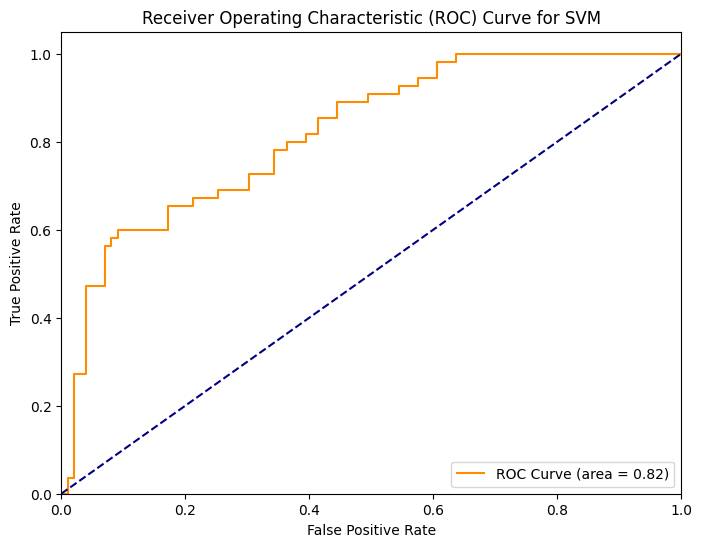

In [9]:
# Fit the model with probability enabled
svm_model.fit(X_train_scaled, y_train)

# Predict probabilities for the test set
y_probs_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs_svm)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for SVM')
plt.legend(loc="lower right")
plt.show()


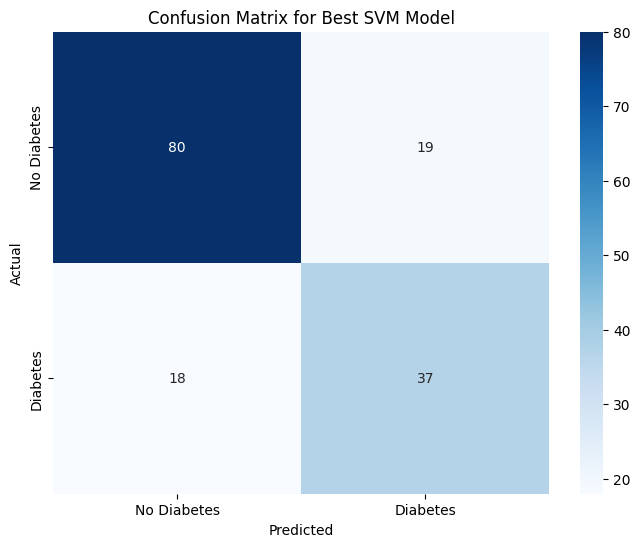

In [16]:

# Confusion Matrix for the best model (after GridSearchCV)
conf_matrix = best_svm_expanded_conf_matrix

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', 
            xticklabels=['No Diabetes', 'Diabetes'], 
            yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Best SVM Model')
plt.show()


**Function to Predict**

In [18]:
def predict_with_confidence(best_svm_expanded, scaler,Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, threshold=0.5):
    import numpy as np

    # Create an array from the input features
    features = np.array([[Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age]])
    
    # Scale the features using the provided scaler
    features_scaled = scaler.transform(features)
    
    # Predict the probability of diabetes using the best model
    probability = best_svm_expanded.predict_proba(features_scaled)[0, 1]
    
    # Make the prediction based on the specified threshold
    if probability >= threshold:
        prediction = "Diabetic"
    else:
        prediction = "Non-Diabetic"
    
    # Return the prediction and confidence (probability)
    return prediction, probability

# Example usage:
# Assuming best_svm_expanded and scaler are already defined and trained
result, confidence = predict_with_confidence(best_svm_expanded, scaler,2, 120, 70, 30, 85, 32.0, 0.627, 50)
print(f"Prediction: {result}, Confidence: {confidence:.2f}")


Prediction: Non-Diabetic, Confidence: 0.49


C:\Users\Al-Hussain Com\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
